## 1 Data Preprocessing

In [1]:
import re
import requests
import bs4
import pandas as pd
import geopandas as gpd
import math
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import sqlalchemy

In [2]:
import warnings
warnings.filterwarnings("ignore")

### 1.1 Preprocessing Yellow taxi trips data

### 1.1.1 downloading data from web


In [3]:
TAXI_URL = "https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

# Retrieves yellow taxi trip records from the given website. 
def get_taxi_html(): 
    response = requests.get(TAXI_URL)
    html = response.content
    return html

# Send HTTP GET requests to the website, and parse the HTML content and extract links. 
def find_taxi_parquet_links(): 
    taxi_html = get_taxi_html()
    soup = bs4.BeautifulSoup(taxi_html, "html.parser")
    # print(soup.prettify())
    p_link = []
    for item in soup.find_all('a'):
        if "yellow taxi trip records" in item.text.lower():
            p_link.append(item.get('href'))  
            
    return p_link

In [4]:
# Downloads the data from the extracted links as Parquet files
def download_parquet(url_list):
    i = 0
    for url in url_list:
        i += 1
        r = requests.get(url, allow_redirects=True)
        open(f'taxi{i}.parquet', 'wb').write(r.content)
        print(f"write {i} successfully")
        

In [5]:
url_list = find_taxi_parquet_links()

In [6]:
len(url_list)

169

In [7]:
for link in url_list:
    print(link)

https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-02.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-03.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-04.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-05.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-06.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-07.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-08.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-09.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-10.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-11.parquet
https://d37ci6vzurychx.cloudfront.net/tr

In [8]:
## have been finished and only need to execute one time
# download_parquet(url_list)

### 1.1.2 Cleaning & filtering

In [9]:
## Sampling & downloading for yellow taxi trips

In [10]:
# Read all parquet files
import random
n = len(url_list)
# from June 2015 -> Jan 2009
i = 89
print("start reading!")
tmp_pq = pd.read_parquet(f'taxi{i}.parquet')
ye_taxi_pq = tmp_pq.sample(n=250, random_state=1)
while(i<=166):
    print(f"finish reading {i}")
    i += 1
    tmp_pq = pd.read_parquet(f'taxi{i}.parquet')
    # sample: each month keep 4000 data and combine them to a roughly 200000-row dataframe
    sample_tmp_pq = tmp_pq.sample(n=4000, random_state=1)
    ye_taxi_pq = pd.concat([ye_taxi_pq, sample_tmp_pq])
ye_taxi_pq

start reading!
finish reading 89
finish reading 90
finish reading 91
finish reading 92
finish reading 93
finish reading 94
finish reading 95
finish reading 96
finish reading 97
finish reading 98
finish reading 99
finish reading 100
finish reading 101
finish reading 102
finish reading 103
finish reading 104
finish reading 105
finish reading 106
finish reading 107
finish reading 108
finish reading 109
finish reading 110
finish reading 111
finish reading 112
finish reading 113
finish reading 114
finish reading 115
finish reading 116
finish reading 117
finish reading 118
finish reading 119
finish reading 120
finish reading 121
finish reading 122
finish reading 123
finish reading 124
finish reading 125
finish reading 126
finish reading 127
finish reading 128
finish reading 129
finish reading 130
finish reading 131
finish reading 132
finish reading 133
finish reading 134
finish reading 135
finish reading 136
finish reading 137
finish reading 138
finish reading 139
finish reading 140
finish r

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,Start_Lat,Rate_Code,store_and_forward,End_Lon,End_Lat,Payment_Type,Fare_Amt,Tip_Amt,Tolls_Amt,Total_Amt
488064,2.0,2015-06-02 08:37:30,2015-06-02 08:47:15,1.0,1.10,1.0,N,234.0,113.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5073891,1.0,2015-06-12 22:59:41,2015-06-12 23:12:10,1.0,1.90,1.0,N,137.0,4.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8611696,2.0,2015-06-21 15:23:01,2015-06-21 15:26:14,2.0,0.75,1.0,N,158.0,68.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3777133,1.0,2015-06-09 23:55:41,2015-06-10 00:01:48,1.0,1.40,1.0,N,236.0,238.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5052093,1.0,2015-06-12 22:56:36,2015-06-12 23:25:27,1.0,2.10,1.0,N,163.0,170.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10089537,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.754909,NaN,0.0,-73.994973,40.760164,Cash,4.5,0.0,0.0,5.0
9202173,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.740975,NaN,0.0,-74.005627,40.733261,Cash,4.1,0.0,0.0,5.6
3675040,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.771276,NaN,NaN,-73.980070,40.779761,CASH,7.3,0.0,0.0,7.8
5867047,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.779477,NaN,NaN,-73.975965,40.792175,Credit,5.3,0.5,0.0,6.3


In [11]:
# read the data of zones
zones_gdf = gpd.read_file('taxi_zones.shp')
zones_gdf

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


In [12]:
# use the “center” of the zones (polygons) as a point to look up the coordinates

In [13]:
zones_gdf = zones_gdf.to_crs(4326)
zones_gdf['lon'] = zones_gdf.centroid.x  
zones_gdf['lat'] = zones_gdf.centroid.y
zones_gdf

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,lon,lat
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",-74.174000,40.691831
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",-73.831299,40.616745
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",-73.847422,40.864474
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",-73.976968,40.723752
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",-74.188484,40.552659
...,...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((-73.85107 40.91037, -73.85207 40.909...",-73.852215,40.897932
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((-73.90175 40.76078, -73.90147 40.759...",-73.906306,40.744235
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((-74.01333 40.70503, -74.01327 40.704...",-74.013023,40.709139
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ...",-73.946510,40.775932


In [14]:
len(ye_taxi_pq)

312250

In [15]:
# only keeping columns needed
# according to the sample data
cleaned_df = ye_taxi_pq[["fare_amount", "tpep_pickup_datetime", "PULocationID", "DOLocationID", "passenger_count", "tip_amount"]]

In [16]:
## drop invalid location ID
pickup_valid = cleaned_df["PULocationID"] < 264
dropof_valid = cleaned_df["DOLocationID"] < 264
cleaned_df = cleaned_df[pickup_valid & dropof_valid]

In [17]:
len(cleaned_df)

210647

In [18]:
# rename column
cleaned_df.rename(columns={"tpep_pickup_datetime": "pickup_datetime"}, inplace=True)
cleaned_df.rename(columns={"tip_amount": "tips"}, inplace=True)
cleaned_df

,fare_amount,pickup_datetime,PULocationID,DOLocationID,passenger_count,tips
488064,7.5,2015-06-02 08:37:30,234.0,113.0,1.0,0.00
5073891,10.0,2015-06-12 22:59:41,137.0,4.0,1.0,0.00
8611696,4.5,2015-06-21 15:23:01,158.0,68.0,2.0,0.00
3777133,7.0,2015-06-09 23:55:41,236.0,238.0,1.0,1.00
5052093,17.5,2015-06-12 22:56:36,163.0,170.0,1.0,0.00
...,...,...,...,...,...,...
11735739,14.9,2011-12-23 19:56:00,142.0,79.0,5.0,0.00
8492593,12.1,2011-12-17 10:13:12,87.0,233.0,1.0,2.00
3460249,6.9,2011-12-07 20:13:00,237.0,75.0,1.0,0.00
1159551,7.7,2011-12-03 03:52:42,79.0,186.0,1.0,2.17


In [19]:
# add latitude and longtitude
pid = cleaned_df["PULocationID"]-1
cleaned_df["pickup_longtitude"] = zones_gdf["lon"][pid].values
cleaned_df["pickup_latitude"] = zones_gdf["lat"][pid].values

did = cleaned_df["DOLocationID"]-1
cleaned_df["dropoff_longtitude"] = zones_gdf["lon"][did].values
cleaned_df["dropoff_latitude"] = zones_gdf["lat"][did].values

In [20]:
# drop off the columns that is no longer needed
cleaned_df = cleaned_df.drop(["PULocationID", "DOLocationID"], axis=1)

In [21]:
# make an copy in case
copy_df = cleaned_df.copy()
copy_df

,fare_amount,pickup_datetime,passenger_count,tips,pickup_longtitude,pickup_latitude,dropoff_longtitude,dropoff_latitude
488064,7.5,2015-06-02 08:37:30,1.0,0.00,-73.990458,40.740337,-73.994305,40.732579
5073891,10.0,2015-06-12 22:59:41,1.0,0.00,-73.976495,40.740439,-73.976968,40.723752
8611696,4.5,2015-06-21 15:23:01,2.0,0.00,-74.008984,40.735035,-73.999917,40.748428
3777133,7.0,2015-06-09 23:55:41,1.0,1.00,-73.957012,40.780436,-73.973049,40.791705
5052093,17.5,2015-06-12 22:56:36,1.0,0.00,-73.977569,40.764421,-73.978492,40.747746
...,...,...,...,...,...,...,...,...
11735739,14.9,2011-12-23 19:56:00,5.0,0.00,-73.981532,40.773633,-73.985937,40.727620
8492593,12.1,2011-12-17 10:13:12,1.0,2.00,-74.007496,40.706808,-73.970443,40.749914
3460249,6.9,2011-12-07 20:13:00,1.0,0.00,-73.965635,40.768615,-73.945750,40.790011
1159551,7.7,2011-12-03 03:52:42,1.0,2.17,-73.985937,40.727620,-73.992438,40.748497


In [22]:
# just keep valid lon&lat
# removing trips that start and/or end outside of the
# following latitude/longitude coordinate box:
# (40.560445, -74.242330) and (40.908524, -73.717047).

valid_pick_lon = (cleaned_df["pickup_longtitude"] > -74.242330) & (cleaned_df["pickup_longtitude"] < -73.717047)
valid_pick_lat = (cleaned_df["pickup_latitude"] > 40.560445) & (cleaned_df["pickup_latitude"] < 40.908524)

valid_drop_lon = (cleaned_df["dropoff_longtitude"] > -74.242330) & (cleaned_df["dropoff_longtitude"] < -73.717047)
valid_drop_lat = (cleaned_df["dropoff_latitude"] > 40.560445) & (cleaned_df["dropoff_latitude"] < 40.908524)

cleaned_df = cleaned_df[valid_pick_lon & valid_pick_lat & valid_drop_lon & valid_drop_lat]

In [24]:
# drop NaN
cleaned_df = cleaned_df.dropna()
len(cleaned_df)

210628

In [25]:
## take a look for yellow taxi trips data
cleaned_df

,fare_amount,pickup_datetime,passenger_count,tips,pickup_longtitude,pickup_latitude,dropoff_longtitude,dropoff_latitude
488064,7.5,2015-06-02 08:37:30,1.0,0.00,-73.990458,40.740337,-73.994305,40.732579
5073891,10.0,2015-06-12 22:59:41,1.0,0.00,-73.976495,40.740439,-73.976968,40.723752
8611696,4.5,2015-06-21 15:23:01,2.0,0.00,-74.008984,40.735035,-73.999917,40.748428
3777133,7.0,2015-06-09 23:55:41,1.0,1.00,-73.957012,40.780436,-73.973049,40.791705
5052093,17.5,2015-06-12 22:56:36,1.0,0.00,-73.977569,40.764421,-73.978492,40.747746
...,...,...,...,...,...,...,...,...
11735739,14.9,2011-12-23 19:56:00,5.0,0.00,-73.981532,40.773633,-73.985937,40.727620
8492593,12.1,2011-12-17 10:13:12,1.0,2.00,-74.007496,40.706808,-73.970443,40.749914
3460249,6.9,2011-12-07 20:13:00,1.0,0.00,-73.965635,40.768615,-73.945750,40.790011
1159551,7.7,2011-12-03 03:52:42,1.0,2.17,-73.985937,40.727620,-73.992438,40.748497


In [26]:
# transfer date columns to time columns
def set_times(renamed_data):
    renamed_data["year"] = renamed_data["pickup_datetime"].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").year )
    renamed_data["month"] = renamed_data["pickup_datetime"].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").month )
    renamed_data["day"] = renamed_data["pickup_datetime"].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").day )
    renamed_data["hour"] = renamed_data["pickup_datetime"].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").hour )
    
    return renamed_data

set_times(cleaned_df)

,fare_amount,pickup_datetime,passenger_count,tips,pickup_longtitude,pickup_latitude,dropoff_longtitude,dropoff_latitude,year,month,day,hour
488064,7.5,2015-06-02 08:37:30,1.0,0.00,-73.990458,40.740337,-73.994305,40.732579,2015,6,2,8
5073891,10.0,2015-06-12 22:59:41,1.0,0.00,-73.976495,40.740439,-73.976968,40.723752,2015,6,12,22
8611696,4.5,2015-06-21 15:23:01,2.0,0.00,-74.008984,40.735035,-73.999917,40.748428,2015,6,21,15
3777133,7.0,2015-06-09 23:55:41,1.0,1.00,-73.957012,40.780436,-73.973049,40.791705,2015,6,9,23
5052093,17.5,2015-06-12 22:56:36,1.0,0.00,-73.977569,40.764421,-73.978492,40.747746,2015,6,12,22
...,...,...,...,...,...,...,...,...,...,...,...,...
11735739,14.9,2011-12-23 19:56:00,5.0,0.00,-73.981532,40.773633,-73.985937,40.727620,2011,12,23,19
8492593,12.1,2011-12-17 10:13:12,1.0,2.00,-74.007496,40.706808,-73.970443,40.749914,2011,12,17,10
3460249,6.9,2011-12-07 20:13:00,1.0,0.00,-73.965635,40.768615,-73.945750,40.790011,2011,12,7,20
1159551,7.7,2011-12-03 03:52:42,1.0,2.17,-73.985937,40.727620,-73.992438,40.748497,2011,12,3,3


In [27]:
## take a look for yellow taxi trips data
cleaned_df

,fare_amount,pickup_datetime,passenger_count,tips,pickup_longtitude,pickup_latitude,dropoff_longtitude,dropoff_latitude,year,month,day,hour
488064,7.5,2015-06-02 08:37:30,1.0,0.00,-73.990458,40.740337,-73.994305,40.732579,2015,6,2,8
5073891,10.0,2015-06-12 22:59:41,1.0,0.00,-73.976495,40.740439,-73.976968,40.723752,2015,6,12,22
8611696,4.5,2015-06-21 15:23:01,2.0,0.00,-74.008984,40.735035,-73.999917,40.748428,2015,6,21,15
3777133,7.0,2015-06-09 23:55:41,1.0,1.00,-73.957012,40.780436,-73.973049,40.791705,2015,6,9,23
5052093,17.5,2015-06-12 22:56:36,1.0,0.00,-73.977569,40.764421,-73.978492,40.747746,2015,6,12,22
...,...,...,...,...,...,...,...,...,...,...,...,...
11735739,14.9,2011-12-23 19:56:00,5.0,0.00,-73.981532,40.773633,-73.985937,40.727620,2011,12,23,19
8492593,12.1,2011-12-17 10:13:12,1.0,2.00,-74.007496,40.706808,-73.970443,40.749914,2011,12,17,10
3460249,6.9,2011-12-07 20:13:00,1.0,0.00,-73.965635,40.768615,-73.945750,40.790011,2011,12,7,20
1159551,7.7,2011-12-03 03:52:42,1.0,2.17,-73.985937,40.727620,-73.992438,40.748497,2011,12,3,3


### 1.1.3 Calculating missing data for yellow taxi trips

In [28]:
# for yellow taxi trips
## calculate distance between pickup and dropoff
## by using the Haversine Formula

def to_dist(lat1, lon1, lat2, lon2):    
    R = 6371  # radius of the Earth in kilometers
    dLat = lat2.apply(math.radians) - lat1.apply(math.radians)
    dLon = lon2.apply(math.radians) - lon1.apply(math.radians)
    lat1 = lat1.apply(math.radians)
    lat2 = lat2.apply(math.radians)
    a = (dLat / 2).apply(math.sin) ** 2 + (dLat / 2).apply(math.sin) ** 2 * lat1.apply(math.cos) * lat2.apply(math.cos)
    c = 2 * np.arctan2(a.apply(math.sqrt), (1 - a).apply(math.sqrt))    
#     print("dlat", dLat, "\ndlon", dLon, "\nlat1", lat1, "\nlat2", lat2, "\na", a, "\nc", c)
#     print(type(dLat))
    return R * c

In [29]:
cleaned_df["distance"] = to_dist(cleaned_df["pickup_latitude"].astype(float), cleaned_df["pickup_longtitude"].astype(float), cleaned_df["dropoff_latitude"].astype(float), cleaned_df["dropoff_longtitude"].astype(float))
cleaned_df    

,fare_amount,pickup_datetime,passenger_count,tips,pickup_longtitude,pickup_latitude,dropoff_longtitude,dropoff_latitude,year,month,day,hour,distance
488064,7.5,2015-06-02 08:37:30,1.0,0.00,-73.990458,40.740337,-73.994305,40.732579,2015,6,2,8,1.082373
5073891,10.0,2015-06-12 22:59:41,1.0,0.00,-73.976495,40.740439,-73.976968,40.723752,2015,6,12,22,2.328042
8611696,4.5,2015-06-21 15:23:01,2.0,0.00,-74.008984,40.735035,-73.999917,40.748428,2015,6,21,15,1.868290
3777133,7.0,2015-06-09 23:55:41,1.0,1.00,-73.957012,40.780436,-73.973049,40.791705,2015,6,9,23,1.571644
5052093,17.5,2015-06-12 22:56:36,1.0,0.00,-73.977569,40.764421,-73.978492,40.747746,2015,6,12,22,2.326170
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11735739,14.9,2011-12-23 19:56:00,5.0,0.00,-73.981532,40.773633,-73.985937,40.727620,2011,12,23,19,6.418804
8492593,12.1,2011-12-17 10:13:12,1.0,2.00,-74.007496,40.706808,-73.970443,40.749914,2011,12,17,10,6.013948
3460249,6.9,2011-12-07 20:13:00,1.0,0.00,-73.965635,40.768615,-73.945750,40.790011,2011,12,7,20,2.984202
1159551,7.7,2011-12-03 03:52:42,1.0,2.17,-73.985937,40.727620,-73.992438,40.748497,2011,12,3,3,2.912530


### 1.2 Preprocessing Weather data

In [30]:
# read weather
i = 2009
weather_dfs = [pd.read_csv(f'{i}_weather.csv')]
print(f"finish reading weather in {i}")
while(i < 2015):
    i += 1
    tmp_pq = pd.read_csv(f'{i}_weather.csv')
    weather_dfs.append(tmp_pq) 
    print(f"finish reading weather in {i}")
weather_dfs = pd.concat(weather_dfs, ignore_index = True)
weather_dfs

finish reading weather in 2009
finish reading weather in 2010
finish reading weather in 2011
finish reading weather in 2012
finish reading weather in 2013
finish reading weather in 2014
finish reading weather in 2015


,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,...,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,WindEquipmentChangeDate
0,72505394728,2009-01-01T00:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.01,3.0,...,ESE,0.5,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18
1,72505394728,2009-01-01T01:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.03,3.0,...,ESE,0.5,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18
2,72505394728,2009-01-01T02:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.07,3.0,...,ESE,0.5,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18
3,72505394728,2009-01-01T03:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.09,3.0,...,ESE,0.5,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18
4,72505394728,2009-01-01T04:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.12,3.0,...,ESE,0.5,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77967,72505394728,2015-12-31T21:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,6,30.12,26.0,...,ESE,0.5,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18
77968,72505394728,2015-12-31T22:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,30.11,28.0,...,ESE,0.5,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18
77969,72505394728,2015-12-31T23:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,30.1,26.0,...,ESE,0.5,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18
77970,72505394728,2015-12-31T23:59:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",SOD,6,NaN,NaN,...,ESE,0.5,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18


In [31]:
def clean_weather_data_daily(weather_df):
    #add related daily columns
    tmp_df2 = pd.merge(weather_df['DATE'], weather_df['DailyAverageWindSpeed'], left_index=True, right_index=True)
    tmp_df2 = weather_df[['DATE', 'DailyAverageWindSpeed']]  
    tmp_df2 = tmp_df2.rename(columns=str.lower) #column name: lower letter
    tmp_df2['date'] = pd.to_datetime(tmp_df2.date)
    tmp_df2['date'] = tmp_df2['date'].dt.date
    tmp_df2['date'] = pd.to_datetime(tmp_df2.date) #datetime type  
    res = pd.DataFrame(tmp_df2.groupby('date')['dailyaveragewindspeed'].mean()).reset_index() #groupby date to form daily data
    return res

In [32]:
def clean_weather_data_hourly(weather_df):    
    df2 = weather_df[['DATE', 'DailySustainedWindSpeed', 'DailyPrecipitation', 'HourlyPrecipitation']]  
    df2.loc[df2['HourlyPrecipitation'] == 'T','HourlyPrecipitation'] = 0 # T to 0
    df2 = df2.drop(df2[df2['HourlyPrecipitation'].str.contains(pat = 's') == True].index) # data including 1.2s 
    df2['HourlyPrecipitation'] = df2['HourlyPrecipitation'].astype(float) # to float type 
    df2.loc[df2['DailyPrecipitation'] == 'T','DailyPrecipitation'] = 0 
    df2['DailyPrecipitation'] = pd.to_numeric(df2['DailyPrecipitation'], errors = 'coerce')
    df2 = df2.rename(columns = str.lower)
    df2['date'] = pd.to_datetime(df2.date)
    return df2

In [33]:
daily = clean_weather_data_daily(weather_dfs)
daily

,date,dailyaveragewindspeed
0,2009-01-01,NaN
1,2009-01-02,NaN
2,2009-01-03,NaN
3,2009-01-04,NaN
4,2009-01-05,NaN
...,...,...
2546,2015-12-27,5.7
2547,2015-12-28,8.3
2548,2015-12-29,7.0
2549,2015-12-30,4.1


In [34]:
def load_and_clean_weather_data(weather_dfs):

    hour = pd.DataFrame(clean_weather_data_hourly(weather_dfs)).reset_index()
    # hourly data cleaning
    hour['dateh'] = hour['date'].dt.strftime('%Y-%m-%d %H')
    hour = hour.groupby(['dateh']).agg({'date': 'last', 'dailysustainedwindspeed': 'mean',
                                         'dailyprecipitation': 'mean', 'hourlyprecipitation': 'mean'})

    # hourly precipitation
    # 1. Use daily precipitation /24 to estimate missing hourly precipitation
    hour.loc[hour.hourlyprecipitation.isnull() == True, 'hourlyprecipitation'] = \
        hour.loc[hour.hourlyprecipitation.isnull() == True, 'dailyprecipitation'] / 24

    # 2. use average of windows to fill the missing value
    roll = pd.DataFrame(hour.hourlyprecipitation.rolling(window=24, min_periods=1).mean())
    roll.columns = ['hourlyprecipitation_roll']
    hour = pd.merge(hour, roll, left_index=True, right_index=True)

    hour.loc[((hour['hourlyprecipitation'].isnull() == True) &
              (hour['hourlyprecipitation_roll'].isnull() == False)),
             'hourlyprecipitation'] = hour.loc[((hour['hourlyprecipitation'].isnull() == True) &
                                                (hour['hourlyprecipitation_roll'].isnull() == False)),
                                               'hourlyprecipitation_roll']

    # 3. the rest fill with 0
    hour.loc[(hour['hourlyprecipitation'].isnull() == True), 'hourlyprecipitation'] = 0
    del hour['dailyprecipitation'], hour['hourlyprecipitation_roll']

    # sustained wind speed
    hour['ymd'] = hour.date.dt.strftime('%Y-%m-%d')
    new = pd.DataFrame(hour.groupby('ymd')['dailysustainedwindspeed'].mean())
    new.columns = ['sustainedwindspeed']
    new = new.reset_index()
    hour = pd.merge(hour, new, on='ymd')
    del hour['dailysustainedwindspeed'], hour['ymd']

    hour = hour.reset_index(drop=True) 
    daily1 = daily.reset_index() 
    daily1['date'] = daily['date'].dt.date
    daily1 = daily1.drop(columns = 'index')

    return hour, daily1

weather_hourly = load_and_clean_weather_data(weather_dfs)[0]
weather_daily = load_and_clean_weather_data(weather_dfs)[1]

In [35]:
weather_hourly

,date,hourlyprecipitation,sustainedwindspeed
0,2009-01-01 00:51:00,0.0,NaN
1,2009-01-01 01:51:00,0.0,NaN
2,2009-01-01 02:51:00,0.0,NaN
3,2009-01-01 03:51:00,0.0,NaN
4,2009-01-01 04:51:00,0.0,NaN
...,...,...,...
60436,2015-12-31 19:51:00,0.0,14.0
60437,2015-12-31 20:51:00,0.0,14.0
60438,2015-12-31 21:51:00,0.0,14.0
60439,2015-12-31 22:51:00,0.0,14.0


In [36]:
weather_daily

,date,dailyaveragewindspeed
0,2009-01-01,NaN
1,2009-01-02,NaN
2,2009-01-03,NaN
3,2009-01-04,NaN
4,2009-01-05,NaN
...,...,...
2546,2015-12-27,5.7
2547,2015-12-28,8.3
2548,2015-12-29,7.0
2549,2015-12-30,4.1


### 1.3 Preprocessing Uber Rides data

In [37]:
# read samples for uber rides
uber_rides = pd.read_csv('uber_rides_sample.csv')

In [38]:
len(uber_rides)

200000

In [39]:
uber_rides

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [40]:
# datetime processing
uber_rides = uber_rides.iloc[:,2:] 
uber_rides["pickup_datetime"] = pd.to_datetime(uber_rides["pickup_datetime"]) 
uber_rides['pickup_datetime'] = uber_rides['pickup_datetime'].dt.tz_localize(None)


In [41]:
# date to time columns
def set_times(renamed_data):
    renamed_data["year"] = renamed_data["pickup_datetime"].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").year )
    renamed_data["month"] = renamed_data["pickup_datetime"].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").month )
    renamed_data["day"] = renamed_data["pickup_datetime"].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").day )
    renamed_data["hour"] = renamed_data["pickup_datetime"].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").hour )
    renamed_data['week'] = renamed_data['pickup_datetime'].dt.dayofweek + 1 
    return renamed_data

set_times(uber_rides)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,week
0,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,4
1,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,5
2,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,1
3,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,5
4,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,4
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00,-73.987042,40.739367,-73.986525,40.740297,1,2012,10,28,10,7
199996,7.5,2014-03-14 01:09:00,-73.984722,40.736837,-74.006672,40.739620,1,2014,3,14,1,5
199997,30.9,2009-06-29 00:42:00,-73.986017,40.756487,-73.858957,40.692588,2,2009,6,29,0,1
199998,14.5,2015-05-20 14:56:25,-73.997124,40.725452,-73.983215,40.695415,1,2015,5,20,14,3


In [42]:
# for uber trips
## calculate distance between pickup and dropoff
## by using the Haversine Formula

def to_dist(lat1, lon1, lat2, lon2):    
    R = 6371  # radius of the Earth in kilometers
    dLat = lat2.apply(math.radians) - lat1.apply(math.radians)
    dLon = lon2.apply(math.radians) - lon1.apply(math.radians)
    lat1 = lat1.apply(math.radians)
    lat2 = lat2.apply(math.radians)
    a = (dLat / 2).apply(math.sin) ** 2 + (dLat / 2).apply(math.sin) ** 2 * lat1.apply(math.cos) * lat2.apply(math.cos)
    c = 2 * np.arctan2(a.apply(math.sqrt), (1 - a).apply(math.sqrt))    
    return R * c

# cleaned_df["distance"] = to_dist(cleaned_df["pickup_latitude"], cleaned_df["pickup_longitude"], cleaned_df["dropoff_latitude"], cleaned_df["dropoff_longitude"])
uber_rides["distance"] = to_dist(uber_rides["pickup_latitude"], uber_rides["pickup_longitude"], uber_rides["dropoff_latitude"], uber_rides["dropoff_longitude"])
uber_rides  

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,week,distance
0,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,4,2.111795
1,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,5,3.083131
2,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,1,4.446678
3,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,5,1.743997
4,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,4,2.394064
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00,-73.987042,40.739367,-73.986525,40.740297,1,2012,10,28,10,7,0.129742
199996,7.5,2014-03-14 01:09:00,-73.984722,40.736837,-74.006672,40.739620,1,2014,3,14,1,5,0.388254
199997,30.9,2009-06-29 00:42:00,-73.986017,40.756487,-73.858957,40.692588,2,2009,6,29,0,1,8.915154
199998,14.5,2015-05-20 14:56:25,-73.997124,40.725452,-73.983215,40.695415,1,2015,5,20,14,3,4.191060


## 2 Storing Data 

### 2.1 create a database

In [43]:
# first create a connection
from sqlalchemy import create_engine
engine = create_engine(f"sqlite:///4501final_project.db", echo=True)

In [44]:
import logging
sqllogger = logging.getLogger("sqlalchemy.engine.Engine")
formatter = logging.Formatter("[sqlalchemy] %(message)s")
sqllogger.handlers[0].setFormatter(formatter)

from sqlalchemy.orm import declarative_base
Base = declarative_base()

### 2.2 create and populate four tables

In [45]:
from sqlalchemy import Column, Integer, String, Date, Float
from sqlalchemy.orm import validates

# Yellow Taxi trips
class Yellow_Taxi_trips(Base):
    __tablename__ = "Yellow_Taxi_trips"  
    
    id = Column(Integer, primary_key=True)
    fare_amount = Column(Float)
    pickup_datetime = Column(Date)
    passenger_count = Column(Integer)
    tip = Column(Float)
    
    pickup_longtitude = Column(Float)
    pickup_latitude = Column(Float)
    dropoff_longtitude = Column(Float)
    dropoff_latitude = Column(Float)
    distance = Column(Float)
    
    year = Column(Integer)
    month = Column(Integer)
    day = Column(Integer)
    hour = Column(Integer)
    

In [46]:
# Uber trips
class Uber_trips(Base):
    __tablename__ = "Uber_trips"  
    
    id = Column(Integer, primary_key=True)
    fare_amount = Column(Float)
    pickup_datetime = Column(Date)
    passenger_count = Column(Integer)
    
    pickup_longtitude = Column(Float)
    pickup_latitude = Column(Float)
    dropoff_longtitude = Column(Float)
    dropoff_latitude = Column(Float)
    distance = Column(Float)
    
    year = Column(Integer)
    month = Column(Integer)
    day = Column(Integer)
    hour = Column(Integer)
    
    week = Column(Integer)

In [47]:
# hourly weather   
class hourly_weather(Base):
    __tablename__ = "hourly_weather"  
    
    id = Column(Integer, primary_key=True)
    date = Column(String)
    hourlyprecipitation = Column(Float) 
    sustainedwindspeed = Column(Float) 


In [48]:
# daily weather   
class daily_weather(Base):
    __tablename__ = "daily_weather"  
    
    id = Column(Integer, primary_key=True)
    date = Column(String)
    dailyaveragewindspeed = Column(Float) 

### 2.3 create a schema.sql file to store data

In [49]:
# uber rides
with engine.begin() as connection:
    # df = uber_rides
    uber_rides.to_sql('Uber_trips', con=connection, if_exists='replace')

[sqlalchemy] BEGIN (implicit)
[sqlalchemy] PRAGMA main.table_info("Uber_trips")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA main.table_info("Uber_trips")
[sqlalchemy] [raw sql] ()
[sqlalchemy] SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA main.table_xinfo("Uber_trips")
[sqlalchemy] [raw sql] ()
[sqlalchemy] SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
[sqlalchemy] [raw sql] ('Uber_trips',)
[sqlalchemy] PRAGMA main.foreign_key_list("Uber_trips")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.foreign_key_list("Uber_trips")
[sqlalchemy] [raw sql] ()
[sqlalchemy] SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
[sqlalchemy] [raw sql] ('Uber_trips',)
[sqlalchemy] PRAGMA main.index_list("Uber_trips")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA main.index_info("ix_Ub

In [50]:
# Yellow_Taxi_trips
with engine.begin() as connection:
    # df = cleaned_df  
    cleaned_df.to_sql('Yellow_Taxi_trips', con=connection, if_exists='replace')

[sqlalchemy] BEGIN (implicit)
[sqlalchemy] PRAGMA main.table_info("Yellow_Taxi_trips")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA main.table_info("Yellow_Taxi_trips")
[sqlalchemy] [raw sql] ()
[sqlalchemy] SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA main.table_xinfo("Yellow_Taxi_trips")
[sqlalchemy] [raw sql] ()
[sqlalchemy] SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
[sqlalchemy] [raw sql] ('Yellow_Taxi_trips',)
[sqlalchemy] PRAGMA main.foreign_key_list("Yellow_Taxi_trips")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.foreign_key_list("Yellow_Taxi_trips")
[sqlalchemy] [raw sql] ()
[sqlalchemy] SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
[sqlalchemy] [raw sql] ('Yellow_Taxi_trips',)
[sqlalchemy] PRAGMA main.index_list("Yellow_Taxi_trips")
[sqlalchemy]

In [51]:
# hourly_weather
with engine.begin() as connection:
    # df = hourly
    weather_hourly.to_sql('hourly_weather', con=connection, if_exists='replace')

[sqlalchemy] BEGIN (implicit)
[sqlalchemy] PRAGMA main.table_info("hourly_weather")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA main.table_info("hourly_weather")
[sqlalchemy] [raw sql] ()
[sqlalchemy] SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA main.table_xinfo("hourly_weather")
[sqlalchemy] [raw sql] ()
[sqlalchemy] SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
[sqlalchemy] [raw sql] ('hourly_weather',)
[sqlalchemy] PRAGMA main.foreign_key_list("hourly_weather")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.foreign_key_list("hourly_weather")
[sqlalchemy] [raw sql] ()
[sqlalchemy] SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
[sqlalchemy] [raw sql] ('hourly_weather',)
[sqlalchemy] PRAGMA main.index_list("hourly_weather")
[sqlalchemy] [raw sql] ()
[sqlalchem

In [52]:
# uber rides
with engine.begin() as connection:
    # df = uber_rides
    weather_daily.to_sql('daily_weather', con=connection, if_exists='append')

[sqlalchemy] BEGIN (implicit)
[sqlalchemy] PRAGMA main.table_info("daily_weather")
[sqlalchemy] [raw sql] ()
[sqlalchemy] INSERT INTO daily_weather ("index", date, dailyaveragewindspeed) VALUES (?, ?, ?)
[sqlalchemy] [generated in 0.00703s] ((0, '2009-01-01', None), (1, '2009-01-02', None), (2, '2009-01-03', None), (3, '2009-01-04', None), (4, '2009-01-05', None), (5, '2009-01-06', None), (6, '2009-01-07', None), (7, '2009-01-08', None)  ... displaying 10 of 2551 total bound parameter sets ...  (2549, '2015-12-30', 4.1), (2550, '2015-12-31', 5.4))
[sqlalchemy] COMMIT


## Part 3: Understanding Data

In [53]:
# the created table name
# Uber_trips/ Yellow_Taxi_trips/ daily_weather/ hourly_weather


### Query 1
For 01-2009 through 06-2015, show the popularity of Yellow Taxi rides for each hour of the day.

The query result should have 24 bins, one for each hour, descending.

In [54]:
# logic to solve problem
# (Yellow Taxi rides)
# date->hour
# groupby hour
# order

In [55]:
# Yellow_Taxi_trips

In [56]:
QUERY_1 = """
    SELECT hour, COUNT(hour) FROM Yellow_Taxi_trips
    GROUP BY hour
    ORDER BY COUNT(hour) DESC
"""
df = pd.read_sql_query(QUERY_1, engine)
print(df)

[sqlalchemy] 
    SELECT hour, COUNT(hour) FROM Yellow_Taxi_trips
    GROUP BY hour
    ORDER BY COUNT(hour) DESC

[sqlalchemy] [raw sql] ()
    hour  COUNT(hour)
0     19        13041
1     18        12540
2     20        12377
3     21        12294
4     22        11857
5     14        10712
6     23        10589
7     12        10389
8     13        10266
9     17        10238
10    15        10082
11    11         9738
12     9         9613
13     8         9593
14    10         9545
15    16         8537
16     0         8333
17     7         7546
18     1         6202
19     2         4623
20     6         4483
21     3         3386
22     4         2468
23     5         2176


In [57]:
with open("popular_hour_of_day_taxi.sql", 'w') as file:
    file.write(QUERY_1)

### Query 2
For the same time frame, show the popularity of Uber rides for each day of the week.

The result should have 7 bins, one for each day, descending.

In [58]:
# logic to solve problem
# (Uber rides)
# date->weekday
# groupby hour
# order

In [59]:
# Uber_trips

In [60]:
QUERY_2 = """
SELECT week, COUNT(*) 
FROM (
    SELECT DISTINCT week, pickup_datetime 
    FROM Uber_trips
) subquery
GROUP BY week
ORDER BY COUNT(*) DESC
"""
engine.execute(QUERY_2).fetchall()


[sqlalchemy] 
SELECT week, COUNT(*) 
FROM (
    SELECT DISTINCT week, pickup_datetime 
    FROM Uber_trips
) subquery
GROUP BY week
ORDER BY COUNT(*) DESC

[sqlalchemy] [raw sql] ()


[(5, 30347),
 (6, 29757),
 (4, 29476),
 (3, 28508),
 (2, 27622),
 (7, 26053),
 (1, 24866)]

In [61]:
with open("popular_day_of_week_uber.sql", 'w') as file:
    file.write(QUERY_2)

### Query 3
What is the 95% percentile of distance traveled for all hired trips during July 2013?

The result should be a float. It’s okay if it’s a single float within a list and/or tuple.

In [62]:
# logic to solve problem
# (Uber rides) & (Yellow Taxi rides)
# filter -> July 2013
# sum

In [63]:
# Uber_trips & Yellow_Taxi_trips

In [64]:
QUERY_3 = """
SELECT distance AS '95%distance' FROM (
  SELECT distance FROM Uber_trips
  WHERE "2013-06-30T00:00" < pickup_datetime AND pickup_datetime < '2013-07-31T00:00:00'
  UNION ALL
  SELECT distance FROM Yellow_Taxi_trips
  WHERE "2013-06-30T00:00" < pickup_datetime AND pickup_datetime < '2013-07-31T00:00:00'
) AS two
ORDER BY distance
LIMIT 1
OFFSET (
  SELECT COUNT(*) * 95 / 100 - 1 FROM (
    SELECT distance FROM Uber_trips
    WHERE "2013-06-30T00:00" < pickup_datetime AND pickup_datetime < '2013-07-31T00:00:00'
    UNION ALL
    SELECT distance FROM Yellow_Taxi_trips
    WHERE "2013-06-30T00:00" < pickup_datetime AND pickup_datetime < '2013-07-31T00:00:00'
  ) AS two_count
);
"""
engine.execute(QUERY_3).fetchall()


[sqlalchemy] 
SELECT distance AS '95%distance' FROM (
  SELECT distance FROM Uber_trips
  WHERE "2013-06-30T00:00" < pickup_datetime AND pickup_datetime < '2013-07-31T00:00:00'
  UNION ALL
  SELECT distance FROM Yellow_Taxi_trips
  WHERE "2013-06-30T00:00" < pickup_datetime AND pickup_datetime < '2013-07-31T00:00:00'
) AS two
ORDER BY distance
LIMIT 1
OFFSET (
  SELECT COUNT(*) * 95 / 100 - 1 FROM (
    SELECT distance FROM Uber_trips
    WHERE "2013-06-30T00:00" < pickup_datetime AND pickup_datetime < '2013-07-31T00:00:00'
    UNION ALL
    SELECT distance FROM Yellow_Taxi_trips
    WHERE "2013-06-30T00:00" < pickup_datetime AND pickup_datetime < '2013-07-31T00:00:00'
  ) AS two_count
);

[sqlalchemy] [raw sql] ()


[(9.1658186274566,)]

In [65]:
with open("95%percentile_distance.sql", 'w') as file:
    file.write(QUERY_3)

### Query 4
What were the top 10 days with the highest number of hired rides for 2009, and what was the
average distance for each day?

The result should be a list of 10 tuples. Each tuple should have three items: a date, an integer
for the number of rides of that date, and a float for the average distance of that date. The list of
tuples should be sorted by total number of rides, descending.

In [66]:
# logic to solve problem
# (Uber rides) & (Yellow Taxi rides)
# 1. 2009 
# groupby days
# order 
# top10
# highest number rides
# 2. average the distance of 10 days


In [67]:
# Uber_trips & Yellow_Taxi_trips

In [68]:
QUERY_4 = """
SELECT DATE(pickup_datetime), COUNT(pickup_datetime), AVG(distance)
FROM (
    SELECT pickup_datetime, distance
    FROM Yellow_Taxi_trips
    WHERE "2009-01-1" < pickup_datetime AND pickup_datetime < '2010-01-01'
    UNION ALL
    SELECT pickup_datetime, distance
    FROM Uber_trips
    WHERE "2009-01-1" < pickup_datetime AND pickup_datetime < '2010-01-01'
) AS ride
GROUP BY DATE(pickup_datetime)
ORDER BY COUNT(pickup_datetime) DESC
LIMIT 10
"""
engine.execute(QUERY_4).fetchall()


[sqlalchemy] 
SELECT DATE(pickup_datetime), COUNT(pickup_datetime), AVG(distance)
FROM (
    SELECT pickup_datetime, distance
    FROM Yellow_Taxi_trips
    WHERE "2009-01-1" < pickup_datetime AND pickup_datetime < '2010-01-01'
    UNION ALL
    SELECT pickup_datetime, distance
    FROM Uber_trips
    WHERE "2009-01-1" < pickup_datetime AND pickup_datetime < '2010-01-01'
) AS ride
GROUP BY DATE(pickup_datetime)
ORDER BY COUNT(pickup_datetime) DESC
LIMIT 10

[sqlalchemy] [raw sql] ()


[('2009-12-11', 127, 2.5405201818849545),
 ('2009-10-23', 124, 2.140202684659889),
 ('2009-08-14', 119, 3.019464010497674),
 ('2009-04-18', 116, 3.064270124946897),
 ('2009-07-09', 113, 3.130650718314474),
 ('2009-05-08', 113, 2.9718319576212147),
 ('2009-01-31', 113, 2.6606760820480866),
 ('2009-05-16', 112, 2.5672340046537516),
 ('2009-07-23', 111, 58.09006568230047),
 ('2009-03-19', 111, 2.971272390190837)]

In [69]:
# engine.execute(QUERY_4).fetchall()

In [70]:
with open("top10days_rides_and_distance.sql", 'w') as file:
    file.write(QUERY_4)

### Query 5
Which 10 days in 2014 were the windiest on average, and how many hired trips were made on
those days?

In [71]:
# logic to solve problem
# (weather) & (Yellow Taxi rides) & (Uber rides)
# 2014 weather
# groupby days
# order
# mean for number rides(yellow trips)


In [72]:
# Yellow_Taxi_trips & Uber_trips

In [73]:
QUERY_5 = """
SELECT * FROM (
    SELECT 
        DATE(daily_weather.date) AS date, 
        daily_weather.dailyaveragewindspeed,  
        (SELECT COUNT(pickup_datetime) FROM Uber_trips 
         WHERE DATE(pickup_datetime) = DATE(daily_weather.date)) +
        (SELECT COUNT(pickup_datetime) FROM Yellow_Taxi_trips 
         WHERE DATE(pickup_datetime) = DATE(daily_weather.date)) AS count
    FROM 
        daily_weather 
    ORDER BY 
        daily_weather.dailyaveragewindspeed DESC 
    LIMIT 10
) subquery
"""
engine.execute(QUERY_5).fetchall()


[sqlalchemy] 
SELECT * FROM (
    SELECT 
        DATE(daily_weather.date) AS date, 
        daily_weather.dailyaveragewindspeed,  
        (SELECT COUNT(pickup_datetime) FROM Uber_trips 
         WHERE DATE(pickup_datetime) = DATE(daily_weather.date)) +
        (SELECT COUNT(pickup_datetime) FROM Yellow_Taxi_trips 
         WHERE DATE(pickup_datetime) = DATE(daily_weather.date)) AS count
    FROM 
        daily_weather 
    ORDER BY 
        daily_weather.dailyaveragewindspeed DESC 
    LIMIT 10
) subquery

[sqlalchemy] [raw sql] ()


[('2012-10-29', 18.8, 47),
 ('2013-03-06', 15.5, 204),
 ('2015-02-15', 14.6, 93),
 ('2014-03-13', 14.1, 246),
 ('2014-03-13', 14.1, 246),
 ('2014-03-13', 14.1, 246),
 ('2014-03-13', 14.1, 246),
 ('2012-12-26', 13.8, 180),
 ('2013-02-08', 13.7, 179),
 ('2014-01-07', 13.1, 220)]

In [74]:
with open("top10_windest_hiredtrips.sql", 'w') as file:
    file.write(QUERY_5)

### Query 6

During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after,
how many trips were taken each hour, and for each hour, how much precipitation did NYC
receive and what was the sustained wind speed?

The result should be a list of roughly 384 tuples, where each tuple is an entry for every single
hour of the given date range, even if no rides were taken, no precipitation was measured, or
there was no wind. Each tuple should have four items: a string for the date and hour, an int for
the number of hired rides in that hour, the float for the total precipitation for that hour, and a float
for the average wind speed for that hour. The list of tuples should be ordered by date+hour,
ascending.

In [75]:
# logic to solve problem
# (weather) & (Yellow Taxi rides) & (Uber rides)
# where Hurricane Sandy (Oct 29-30, 2012) + (-7 & +7)
# -> trips(per hour) & precipitation(per hour) & sustained wind speed


In [76]:
# Uber_trips & Yellow_Taxi_trips

In [77]:
QUERY_6 = """
SELECT strftime('%Y-%m-%d %H', t.pickup_datetime) AS Hour,
       SUM(CASE WHEN t.source = 'Yellow_Taxi_trips' THEN 1 ELSE 0 END) AS yellow_trips,
       SUM(CASE WHEN t.source = 'Uber_trips' THEN 1 ELSE 0 END) AS uber_trips,
       hw.hourlyprecipitation,
       hw.sustainedwindspeed
FROM (
  SELECT 'Yellow_Taxi_trips' AS source, pickup_datetime
  FROM Yellow_Taxi_trips
  WHERE '2012-10-22' < pickup_datetime AND pickup_datetime < '2012-11-06'
  UNION ALL
  SELECT 'Uber_trips' AS source, pickup_datetime
  FROM Uber_trips
  WHERE '2012-10-22' < pickup_datetime AND pickup_datetime < '2012-11-06'
) AS t
JOIN hourly_weather AS hw ON strftime('%Y-%m-%d %H', t.pickup_datetime) = strftime('%Y-%m-%d %H', hw.date)
GROUP BY Hour, hw.hourlyprecipitation, hw.sustainedwindspeed
ORDER BY Hour
"""

In [78]:
#find the total number of tuples
result_set = engine.execute(QUERY_6).fetchall()
num_rows = len(result_set)
print(f"Total number of tuples in QUERY_6: {num_rows}")


[sqlalchemy] 
SELECT strftime('%Y-%m-%d %H', t.pickup_datetime) AS Hour,
       SUM(CASE WHEN t.source = 'Yellow_Taxi_trips' THEN 1 ELSE 0 END) AS yellow_trips,
       SUM(CASE WHEN t.source = 'Uber_trips' THEN 1 ELSE 0 END) AS uber_trips,
       hw.hourlyprecipitation,
       hw.sustainedwindspeed
FROM (
  SELECT 'Yellow_Taxi_trips' AS source, pickup_datetime
  FROM Yellow_Taxi_trips
  WHERE '2012-10-22' < pickup_datetime AND pickup_datetime < '2012-11-06'
  UNION ALL
  SELECT 'Uber_trips' AS source, pickup_datetime
  FROM Uber_trips
  WHERE '2012-10-22' < pickup_datetime AND pickup_datetime < '2012-11-06'
) AS t
JOIN hourly_weather AS hw ON strftime('%Y-%m-%d %H', t.pickup_datetime) = strftime('%Y-%m-%d %H', hw.date)
GROUP BY Hour, hw.hourlyprecipitation, hw.sustainedwindspeed
ORDER BY Hour

[sqlalchemy] [raw sql] ()
Total number of tuples in QUERY_6: 336


In [79]:
with open("Hurricane_trips_precipitation_windspeed_perhour.sql", 'w') as file:
    file.write(QUERY_6)

## Part 4 Visualizing Data

In [80]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
plt=reload(plt)

In [81]:
# should be creating those dataframes from querying the SQL tables

Q1. Create an appropriate visualization for the first query/question in part 3.

In [82]:
# histogram

In [83]:
QUERY_1="""
SELECT hour, COUNT(hour) FROM Yellow_Taxi_trips
GROUP BY hour
ORDER BY COUNT(hour) DESC
"""
visual_df1 = pd.read_sql(QUERY_1, engine.connect())
visual_df1.columns = ['Hour', 'Count']

[sqlalchemy] PRAGMA main.table_info("
SELECT hour, COUNT(hour) FROM Yellow_Taxi_trips
GROUP BY hour
ORDER BY COUNT(hour) DESC
")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("
SELECT hour, COUNT(hour) FROM Yellow_Taxi_trips
GROUP BY hour
ORDER BY COUNT(hour) DESC
")
[sqlalchemy] [raw sql] ()
[sqlalchemy] 
SELECT hour, COUNT(hour) FROM Yellow_Taxi_trips
GROUP BY hour
ORDER BY COUNT(hour) DESC

[sqlalchemy] [raw sql] ()


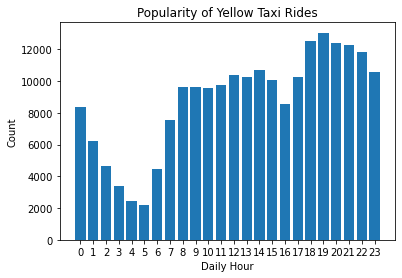

In [84]:
plt.bar(visual_df1["Hour"], visual_df1["Count"])
plt.xlabel("Daily Hour")
plt.ylabel("Count")
plt.title('Popularity of Yellow Taxi Rides')
plt.xticks(np.arange(0,24,1))
plt.show()

### Extra Credit 1:
One extra widget for the first visualization:
This allows user to adjust the hour range and see the corresponding histogram update in real-time.

IntRangeSlider(value=(0, 23), continuous_update=False, description='Hour Range:', max=23)

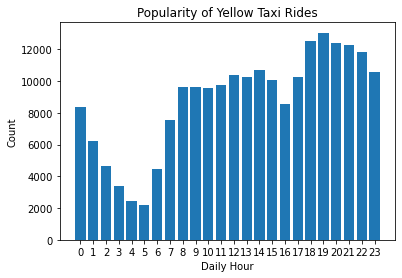

In [85]:
import ipywidgets as widgets
from IPython.display import display

# create a slider widget to control the x-axis range
hour_range = widgets.IntRangeSlider(
    value=[0, 23],
    min=0,
    max=23,
    step=1,
    description='Hour Range:',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# define a function to update the plot based on the slider value
def update_plot(hour_range):
    filtered_df = visual_df1[(visual_df1['Hour'] >= hour_range[0]) & (visual_df1['Hour'] <= hour_range[1])]
    plt.bar(filtered_df['Hour'], filtered_df['Count'])
    plt.xlabel('Daily Hour')
    plt.ylabel('Count')
    plt.title('Popularity of Yellow Taxi Rides')
    plt.xticks(np.arange(hour_range[0], hour_range[1]+1, 1))
    plt.show()

# display the widget and the initial plot
display(hour_range)
update_plot(hour_range.value)

# link the slider value to the update function
hour_range.observe(lambda x: update_plot(hour_range.value), names='value')


Q2. Create a visualization that shows the average distance traveled per month 
(regardless of year - so group by each month) for both taxis and Ubers combined. 
Include the 90% confidence interval around the mean in the visualization.

In [86]:
# ->the average distance
# groupby month
# histogram
# visual_df2

In [87]:
from scipy.stats import norm
def calculate_confidence_interval(data):
    z = norm.ppf(0.9)
    s = data.std()
    n = data.count()
    y_err = z * s / np.sqrt(n)
    return y_err

def plot_visual_confidence(dataframe):
    fig, ax = plt.subplots(figsize=(6,3))
    x = dataframe.index
    y = dataframe['distance']
    y_err = calculate_confidence_interval(y)
    x_ticks = np.linspace(1, 12, 12)
    plt.xticks(x_ticks)
    plt.xlabel('Month')
    plt.ylabel('Distance')
    ax.plot(x, y)
    ax.fill_between(x, y - y_err, y + y_err, alpha=0.2)
    ax.set_title("Confidence level of distance")
    plt.show()

visual_sql="""
    SELECT Date(pickup_datetime) AS date, distance FROM Uber_trips
    UNION 
    SELECT Date(pickup_datetime) AS date, distance FROM Yellow_Taxi_trips
    """
visual_df2 = pd.read_sql(visual_sql, engine.connect())
visual_df2['date'] = pd.to_datetime(visual_df2['date'])
visual_df2['month'] = pd.DatetimeIndex(visual_df2['date']).month
distance_mean = pd.DataFrame(visual_df2.groupby(['month'])['distance'].mean())

[sqlalchemy] PRAGMA main.table_info("
    SELECT Date(pickup_datetime) AS date, distance FROM Uber_trips
    UNION 
    SELECT Date(pickup_datetime) AS date, distance FROM Yellow_Taxi_trips
    ")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("
    SELECT Date(pickup_datetime) AS date, distance FROM Uber_trips
    UNION 
    SELECT Date(pickup_datetime) AS date, distance FROM Yellow_Taxi_trips
    ")
[sqlalchemy] [raw sql] ()
[sqlalchemy] 
    SELECT Date(pickup_datetime) AS date, distance FROM Uber_trips
    UNION 
    SELECT Date(pickup_datetime) AS date, distance FROM Yellow_Taxi_trips
    
[sqlalchemy] [raw sql] ()


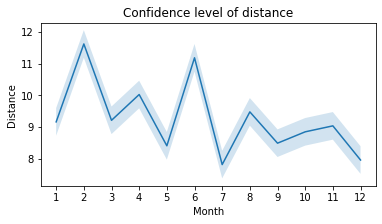

In [88]:
plot_visual_confidence(distance_mean)

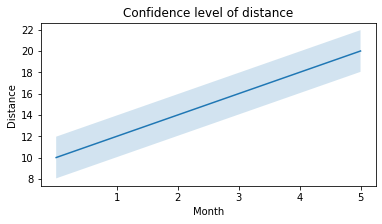

In [89]:
# uni test for function 'plot_visual_confidence'
import unittest
def test_plot_visual_confidence():
    # create a sample DataFrame
    df = pd.DataFrame({
        'month': [1, 2, 3, 4, 5, 6],
        'distance': [10, 12, 14, 16, 18, 20]
    })
    
    # call the function with the sample DataFrame
    plot_visual_confidence(df)
    
    # check if the plot is displayed correctly
    assert len(plt.xticks()[0]) == 6   
    # close the plot
    plt.close()
test_plot_visual_confidence()

Q3. Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR 
    (you can use bboxfinder to help). 
    Create a visualization that compares what day of the week was most popular for drop offs for each airport. 

In [90]:
# bboxfinder    
# week day was most popular(drop offs) for (airport)

In [91]:
def get_data_for_airports():
    airports = {
        'LGA': ((40.765,-73.8893),(40.7864,-73.8512)),
        'JFK': ((40.6211,-73.8232),(40.6648,-73.7484)),
        'EWR': ((40.6704,-74.2151),(40.7114,-74.1132))
    }

    results = {}
    
    for airport, coords in airports.items():
        query = f"""
            WITH RECURSIVE ride AS ( 
                SELECT (strftime ("%w",pickup_datetime)+1) AS Day, pickup_datetime, dropoff_longtitude, dropoff_latitude FROM Yellow_Taxi_trips
                WHERE {coords[0][0]} < dropoff_latitude AND dropoff_latitude < {coords[1][0]} AND {coords[0][1]} < dropoff_longtitude AND dropoff_longtitude < {coords[1][1]}
                UNION ALL
                SELECT (strftime ("%w",pickup_datetime)+1) AS Day, pickup_datetime,dropoff_longitude, dropoff_latitude FROM Uber_trips
                WHERE {coords[0][0]} < dropoff_latitude AND dropoff_latitude < {coords[1][0]} AND {coords[0][1]} < dropoff_longitude AND dropoff_longitude < {coords[1][1]}
            )
            SELECT Day, COUNT(pickup_datetime) FROM ride    
            GROUP BY Day
            ORDER BY COUNT(pickup_datetime) DESC
        """
        
        df = pd.read_sql(query, engine.connect())
        df.replace([1, 2, 3, 4, 5, 6, 7], ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'], inplace=True)
        df.set_index('Day', inplace=True)
        df.columns = [airport]
        results[airport] = df
    
    all_results = pd.concat(list(results.values()), axis=1)
    
    return all_results, results['LGA'], results['JFK'], results['EWR']

In [92]:
def plot_visual_popular_day_dropoffs(Location):
    ALL, LGA_1, JFK_1, EWR_1 = get_data_for_airports()
    if Location == 'LGA':
        LGA_1.plot(kind = 'barh',title = "LGA")
        plt.xlabel('Numbers of dropoffs')
    elif Location == 'JFK':
        JFK_1.plot(kind = 'barh',title = "JFK")
        plt.xlabel('Numbers of dropoffs')
    elif Location == 'EWR':
        EWR_1.plot(kind = 'barh',title = "EWR")
        plt.xlabel('Numbers of dropoffs')
    elif Location == 'ALL':
        ALL.plot(kind = 'bar')
        plt.ylabel('Numbers of dropoffs')
    else:
        Print("---Wrong---")

[sqlalchemy] PRAGMA main.table_info("
            WITH RECURSIVE ride AS ( 
                SELECT (strftime (""%w"",pickup_datetime)+1) AS Day, pickup_datetime, dropoff_longtitude, dropoff_latitude FROM Yellow_Taxi_trips
                WHERE 40.765 < dropoff_latitude AND dropoff_latitude < 40.7864 AND -73.8893 < dropoff_longtitude AND dropoff_longtitude < -73.8512
                UNION ALL
                SELECT (strftime (""%w"",pickup_datetime)+1) AS Day, pickup_datetime,dropoff_longitude, dropoff_latitude FROM Uber_trips
                WHERE 40.765 < dropoff_latitude AND dropoff_latitude < 40.7864 AND -73.8893 < dropoff_longitude AND dropoff_longitude < -73.8512
            )
            SELECT Day, COUNT(pickup_datetime) FROM ride    
            GROUP BY Day
            ORDER BY COUNT(pickup_datetime) DESC
        ")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("
            WITH RECURSIVE ride AS ( 
                SELECT (strftime (""%w"",pickup_datetime)+1) 

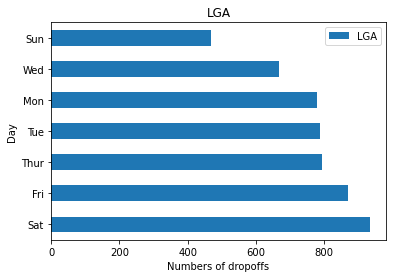

In [93]:
plot_visual_popular_day_dropoffs("LGA")

LGA picture
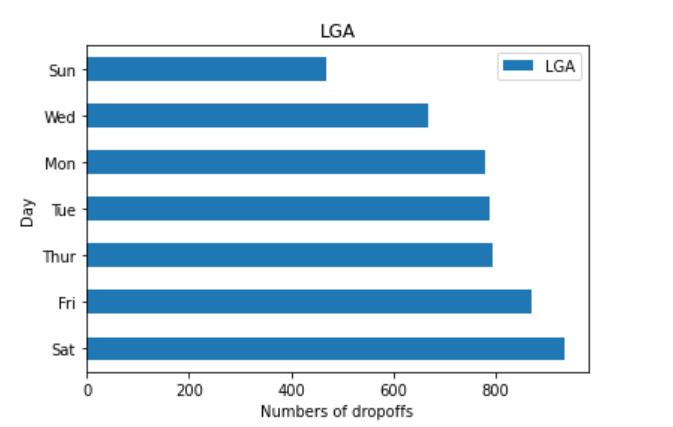

[sqlalchemy] PRAGMA main.table_info("
            WITH RECURSIVE ride AS ( 
                SELECT (strftime (""%w"",pickup_datetime)+1) AS Day, pickup_datetime, dropoff_longtitude, dropoff_latitude FROM Yellow_Taxi_trips
                WHERE 40.765 < dropoff_latitude AND dropoff_latitude < 40.7864 AND -73.8893 < dropoff_longtitude AND dropoff_longtitude < -73.8512
                UNION ALL
                SELECT (strftime (""%w"",pickup_datetime)+1) AS Day, pickup_datetime,dropoff_longitude, dropoff_latitude FROM Uber_trips
                WHERE 40.765 < dropoff_latitude AND dropoff_latitude < 40.7864 AND -73.8893 < dropoff_longitude AND dropoff_longitude < -73.8512
            )
            SELECT Day, COUNT(pickup_datetime) FROM ride    
            GROUP BY Day
            ORDER BY COUNT(pickup_datetime) DESC
        ")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("
            WITH RECURSIVE ride AS ( 
                SELECT (strftime (""%w"",pickup_datetime)+1) 

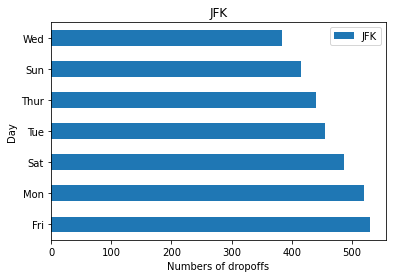

In [94]:
plot_visual_popular_day_dropoffs("JFK")

JFK picture
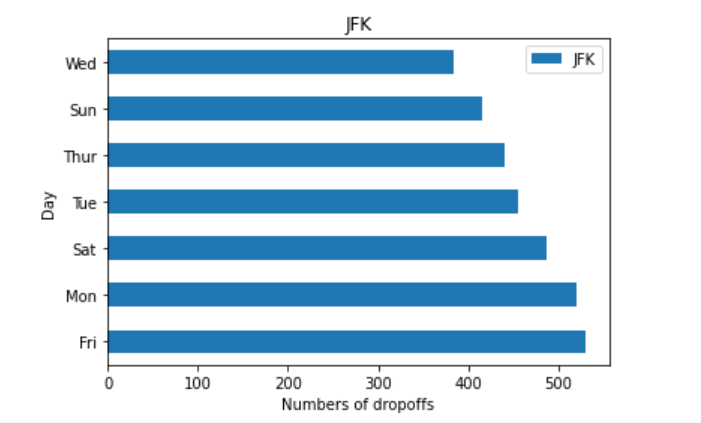

[sqlalchemy] PRAGMA main.table_info("
            WITH RECURSIVE ride AS ( 
                SELECT (strftime (""%w"",pickup_datetime)+1) AS Day, pickup_datetime, dropoff_longtitude, dropoff_latitude FROM Yellow_Taxi_trips
                WHERE 40.765 < dropoff_latitude AND dropoff_latitude < 40.7864 AND -73.8893 < dropoff_longtitude AND dropoff_longtitude < -73.8512
                UNION ALL
                SELECT (strftime (""%w"",pickup_datetime)+1) AS Day, pickup_datetime,dropoff_longitude, dropoff_latitude FROM Uber_trips
                WHERE 40.765 < dropoff_latitude AND dropoff_latitude < 40.7864 AND -73.8893 < dropoff_longitude AND dropoff_longitude < -73.8512
            )
            SELECT Day, COUNT(pickup_datetime) FROM ride    
            GROUP BY Day
            ORDER BY COUNT(pickup_datetime) DESC
        ")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("
            WITH RECURSIVE ride AS ( 
                SELECT (strftime (""%w"",pickup_datetime)+1) 

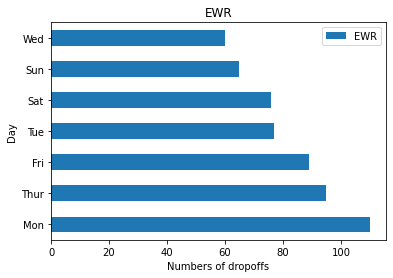

In [95]:
plot_visual_popular_day_dropoffs("EWR")

EWR picture
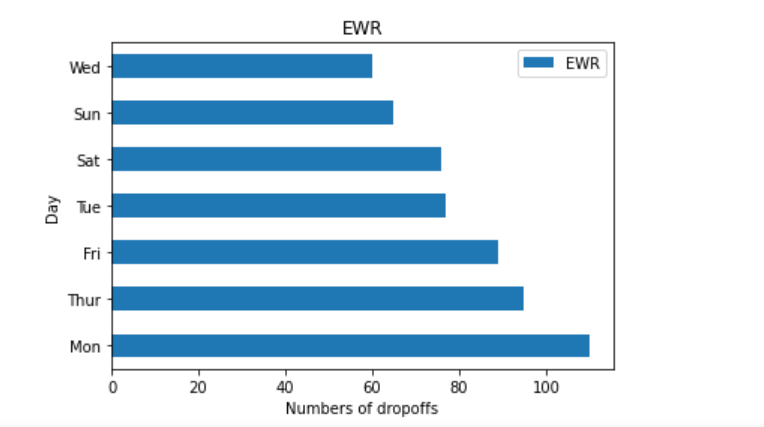

Q4. Create a heatmap of all hired trips over a map of the area. 
Consider using Folium or KeplerGL or another library that helps generate geospatial visualizations.
Depending on the library you use, the visualization may not render when viewing on GitHub 
(after you’ve pushed your code). If that’s the case, please include a screenshot in your repository.

In [96]:
# heatmap
# Will use KeplerGL

In [97]:
visual_sql4 = """
        SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude 
        FROM Uber_trips
        UNION
        SELECT pickup_longtitude, pickup_latitude, dropoff_longtitude, dropoff_latitude 
        FROM Yellow_Taxi_trips
        """
visual_df4 = pd.read_sql(visual_sql4, engine.connect())

[sqlalchemy] PRAGMA main.table_info("
        SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude 
        FROM Uber_trips
        UNION
        SELECT pickup_longtitude, pickup_latitude, dropoff_longtitude, dropoff_latitude 
        FROM Yellow_Taxi_trips
        ")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("
        SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude 
        FROM Uber_trips
        UNION
        SELECT pickup_longtitude, pickup_latitude, dropoff_longtitude, dropoff_latitude 
        FROM Yellow_Taxi_trips
        ")
[sqlalchemy] [raw sql] ()
[sqlalchemy] 
        SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude 
        FROM Uber_trips
        UNION
        SELECT pickup_longtitude, pickup_latitude, dropoff_longtitude, dropoff_latitude 
        FROM Yellow_Taxi_trips
        
[sqlalchemy] [raw sql] ()


In [98]:
 from keplergl import KeplerGl
# execute query and store results in a DataFrame
visual_df4 = pd.read_sql(visual_sql4, engine)

# define the map configuration dictionary and create the KeplerGl instance
map_config = {"version": "v1", "config": {}}
map1 = KeplerGl(height=500, config=map_config)
map1.add_data(data=visual_df4, name='All hired trips')
map1

[sqlalchemy] PRAGMA main.table_info("
        SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude 
        FROM Uber_trips
        UNION
        SELECT pickup_longtitude, pickup_latitude, dropoff_longtitude, dropoff_latitude 
        FROM Yellow_Taxi_trips
        ")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("
        SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude 
        FROM Uber_trips
        UNION
        SELECT pickup_longtitude, pickup_latitude, dropoff_longtitude, dropoff_latitude 
        FROM Yellow_Taxi_trips
        ")
[sqlalchemy] [raw sql] ()
[sqlalchemy] 
        SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude 
        FROM Uber_trips
        UNION
        SELECT pickup_longtitude, pickup_latitude, dropoff_longtitude, dropoff_latitude 
        FROM Yellow_Taxi_trips
        
[sqlalchemy] [raw sql] ()
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {}}, data={'All hired trips': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8…

Q5. Create a scatter plot that compares tip amount versus distance for Yellow Taxi rides. 
    You may remove any outliers how you see fit.

In [99]:
# scatter plot
# (Yellow Taxi rides)
# tip amount vs distance


In [100]:
visual_sql5 = """
    SELECT tips, distance FROM Yellow_Taxi_trips
    WHERE tips >= 0 AND distance > 0
"""
visual_df5 = pd.read_sql(visual_sql5, engine.connect())

[sqlalchemy] PRAGMA main.table_info("
    SELECT tips, distance FROM Yellow_Taxi_trips
    WHERE tips >= 0 AND distance > 0
")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("
    SELECT tips, distance FROM Yellow_Taxi_trips
    WHERE tips >= 0 AND distance > 0
")
[sqlalchemy] [raw sql] ()
[sqlalchemy] 
    SELECT tips, distance FROM Yellow_Taxi_trips
    WHERE tips >= 0 AND distance > 0

[sqlalchemy] [raw sql] ()


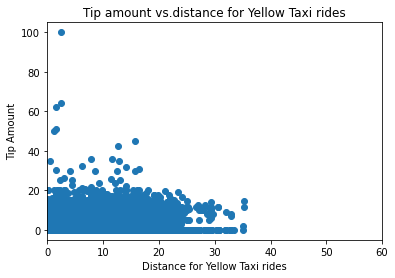

In [101]:
# Create the scatter plot
fig, ax = plt.subplots()
ax.scatter(visual_df5['distance'], visual_df5['tips'])
ax.set_xlabel("Distance for Yellow Taxi rides")
ax.set_xlim(0, 60)
ax.set_ylabel("Tip Amount")
ax.set_title('Tip amount vs.distance for Yellow Taxi rides')
plt.show()

Q6. Create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. 
    You may remove any outliers how you see fit.

In [102]:
# scatter plot
# tip amount versus precipitation amount

In [103]:
visual_sql6 = """
SELECT strftime('%Y-%m-%d %H', pickup_datetime) AS dateh, pickup_datetime, tips
FROM Yellow_Taxi_trips
"""
visual_sql7 = """
SELECT strftime('%Y-%m-%d %H', date) AS dateh, date, hourlyprecipitation 
FROM hourly_weather
"""
taxi_df = pd.read_sql(visual_sql6, engine.connect())
hour_df = pd.read_sql(visual_sql7, engine.connect())
visual_df6 = pd.merge(taxi_df, hour_df, how='left')

[sqlalchemy] PRAGMA main.table_info("
SELECT strftime('%Y-%m-%d %H', pickup_datetime) AS dateh, pickup_datetime, tips
FROM Yellow_Taxi_trips
")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("
SELECT strftime('%Y-%m-%d %H', pickup_datetime) AS dateh, pickup_datetime, tips
FROM Yellow_Taxi_trips
")
[sqlalchemy] [raw sql] ()
[sqlalchemy] 
SELECT strftime('%Y-%m-%d %H', pickup_datetime) AS dateh, pickup_datetime, tips
FROM Yellow_Taxi_trips

[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA main.table_info("
SELECT strftime('%Y-%m-%d %H', date) AS dateh, date, hourlyprecipitation 
FROM hourly_weather
")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("
SELECT strftime('%Y-%m-%d %H', date) AS dateh, date, hourlyprecipitation 
FROM hourly_weather
")
[sqlalchemy] [raw sql] ()
[sqlalchemy] 
SELECT strftime('%Y-%m-%d %H', date) AS dateh, date, hourlyprecipitation 
FROM hourly_weather

[sqlalchemy] [raw sql] ()


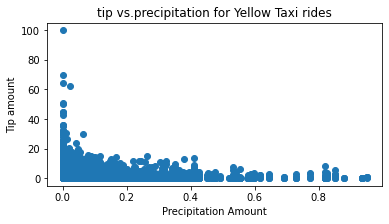

In [104]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(visual_df6['hourlyprecipitation'], visual_df6['tips'], 'o')
ax.set_xlabel('Precipitation Amount')
ax.set_ylabel('Tip amount')
ax.set_title('tip vs.precipitation for Yellow Taxi rides')
plt.show()